# Notebook for Practical Exercises | Week #6 Project

### Foundation Models for Multi-Modal AI

In this notebook, we will leverage the MIMIC-CXR dataset, combining image studies and structured metadata (patient age, sex) to build and compare multi-modal classifiers. This exercise is divided into two main parts:

1.  Multi-Modal Fusion (From Scratch): We will implement and train two fusion models from scratch using a ResNet backbone for image feature extraction.
    *   Concatenation: A simple but effective method of combining image and metadata features.
    *   Cross-Attention: A more advanced technique where metadata is used to selectively focus on relevant image features.

2.  Foundation Model Adaptation: We will select a pre-trained medical Vision-Language Model (MedCLIP) and adapt it to our task using three popular strategies.
    *   Linear Probing: The fastest adaptation method, where only a final classification layer is trained.
    *   Partial Fine-Tuning: Updating a small, newly added classifier head.
    *   LoRA Adaptation: An efficient fine-tuning method that freezes the backbone and trains small "adapter" layers.

Finally, we will compare the performance (AUC, Accuracy, F1) and training cost (trainable parameters) of all five models.

## Dataset

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)


### Download

In [ ]:
DATA_PATH = "./"
!curl https://uni-bonn.sciebo.de/s/cm2Rq2A5nQyQGsb/download/test_df.csv --output test_df.csv
!curl https://uni-bonn.sciebo.de/s/REoaEMzmK8fsmYL/download/train_df.csv --output train_df.csv
!curl https://uni-bonn.sciebo.de/s/K4isoXa6cENkHJp/download/val_df.csv --output val_df.csv

!wget https://uni-bonn.sciebo.de/s/KrMiTk2X7sgBCwK/download/MIMIC-CXR-png.zip -O MIMIC-CXR-png.zip
!unzip MIMIC-CXR-png.zip -d ./

### Setup and Data Loading

First, we'll set up our environment by installing necessary libraries and loading the pre-split MIMIC-CXR dataframes. We will focus on a single diagnostic task for this exercise: binary classification of the pathology.


In [ ]:
!pip install -q transformers peft pandas torch torchvision scikit-learn

In [ ]:
# Install required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModel

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from peft import get_peft_model, LoraConfig, TaskType

warnings.filterwarnings(action="ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
output_dir = './'

train_df = pd.read_csv(os.path.join(output_dir, 'train_df.csv'))
val_df = pd.read_csv(os.path.join(output_dir, 'val_df.csv'))
test_df = pd.read_csv(os.path.join(output_dir, 'test_df.csv'))

print("Dataframes loaded successfully.")

In [ ]:
# Add the absolute image path
IMG_DIR = './MIMIC-CXR-png/files-png'
train_df['img_path'] = train_df.apply(lambda r: os.path.join(IMG_DIR, f"p{r.subject_id}", f"s{r.study_id}", f"{r.dicom_id}.png"), axis=1)
val_df['img_path'] = val_df.apply(lambda r: os.path.join(IMG_DIR, f"p{r.subject_id}", f"s{r.study_id}", f"{r.dicom_id}.png"), axis=1)
test_df['img_path'] = test_df.apply(lambda r: os.path.join(IMG_DIR, f"p{r.subject_id}", f"s{r.study_id}", f"{r.dicom_id}.png"), axis=1)

# Define the Binary Label for pathology
train_df['label'] = train_df['pathology'].astype(int)
val_df['label'] = val_df['pathology'].astype(int)
test_df['label'] = test_df['pathology'].astype(int)

# Drop rows where proxy attributes might be missing
train_df.dropna(subset=['projection', 'is_portable'], inplace=True)
val_df.dropna(subset=['projection', 'is_portable'], inplace=True)
test_df.dropna(subset=['projection', 'is_portable'], inplace=True)


print("\nData loaded and merged for 'pathology' classification.")
print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))


Data loaded and merged for 'pathology' classification.
Training samples: 268
Validation samples: 46
Test samples: 229


### Multi-Modal Fusion (From Scratch)

#### Data Preparation
First, we create a custom `Dataset` class that handles both the image and the structured tabular data (Age, Sex). The tabular data is normalized and one-hot encoded to be suitable for a neural network.


In [ ]:
train_df['projection'].value_counts()

projection
AP    154
PA    114
Name: count, dtype: int64

In [ ]:
# Preprocessing Proxy Attributes
PROJECTION_MAP = {'AP': [1.0, 0.0, 0.0], 'PA': [0.0, 1.0, 0.0]}
# Calculate the size of the tabular feature vector
TABULAR_FEATURE_SIZE = len(PROJECTION_MAP['AP']) + 1  # One-hot for projection + 1 for portable

def preprocess_tabular(projection, is_portable):
    proj_onehot = PROJECTION_MAP.get(projection, [0.0, 0.0, 0.0]) # Default for safety
    port_float = [1.0] if is_portable else [0.0]
    return torch.tensor(proj_onehot + port_float, dtype=torch.float32)

class MultiModalScratchDataset(Dataset):
    def __init__(self, df, is_train=True):
        self.df = df
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['img_path']).convert('RGB')
        image_tensor = self.transform(image)

        tabular_tensor = preprocess_tabular(row['projection'], row['is_portable'])
        label = torch.tensor(row['label'], dtype=torch.float32)

        return image_tensor, tabular_tensor, label

# Create DataLoaders
train_ds_scratch = MultiModalScratchDataset(train_df)
val_ds_scratch = MultiModalScratchDataset(val_df, is_train=False)
test_ds_scratch = MultiModalScratchDataset(test_df, is_train=False)

train_loader = DataLoader(train_ds_scratch, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_ds_scratch, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds_scratch, batch_size=32, shuffle=False, num_workers=2)

print(f"Tabular feature vector size: {TABULAR_FEATURE_SIZE}")

Tabular feature vector size: 4



#### Model Architectures
Here we define our two fusion models from scratch. Both use a pre-trained ResNet-50 as the image feature extractor.

Task: Complete the `forward` pass for both models.


In [ ]:
# Image backbone
def get_resnet_backbone():
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad = False
    num_features = resnet.fc.in_features
    resnet.fc = nn.Identity()
    return resnet, num_features

# Concatenation Model
class ConcatFusionModel(nn.Module):
    def __init__(self, num_img_features, num_tabular_features):
        super().__init__()
        self.image_backbone, _ = get_resnet_backbone()
        self.tabular_mlp = nn.Sequential(nn.Linear(num_tabular_features, 64), nn.ReLU())
        self.classifier = nn.Sequential(
            nn.Linear(num_img_features + 64, 128),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
    def forward(self, image, tabular):
        img_features = self.image_backbone(image)
        tab_features = self.tabular_mlp(tabular)
        # Complete the line below to concatenate the features
        combined = ... # COMPLETE
        return self.classifier(combined)

class CrossAttentionModel(nn.Module):
    def __init__(self, num_img_features, num_tabular_features):
        super().__init__()
        # Backbone returns 2048-dim
        self.image_backbone, _ = get_resnet_backbone()
        # Project those 2048 → 512
        self.img_proj = nn.Linear(num_img_features, 512)

        # Tabular already goes to 512
        self.tabular_mlp = nn.Sequential(
            nn.Linear(num_tabular_features, 512),
            nn.ReLU()
        )

        # Attention over 512-dim
        self.attention = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=4,
            batch_first=True
        )

        # Classifier now sees 512 (attn) + 512 (tab) = 1024
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2, 128),  # was num_img_features + 512 before
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        # image: (B, C, H, W) → (B, 2048)
        img_feat = self.image_backbone(image)
        img_feat = self.img_proj(img_feat)     # → (B, 512)
        img_feat = img_feat.unsqueeze(1)       # → (B, 1, 512)

        # tabular: (B, num_tabular) → (B, 512)
        tab_feat = self.tabular_mlp(tabular)
        tab_feat = tab_feat.unsqueeze(1)       # → (B, 1, 512)

        # cross‐attention
        # Task: Use the tabular features as the query and image features as key/value
        attn_out, _ = self.attention(...) # COMPLETE

        # flatten & classify
        # Task: Concatenate the attention output and tabular features
        combined = torch.cat([...], dim=1) # COMPLETE

        return self.classifier(combined).squeeze(1)


#### Training and Evaluation
We'll now train both models for a few epochs.

Task: Complete the training loop below by adding the backpropagation and optimizer steps. Then, run the training for both scratch models.

In [ ]:
def train_and_evaluate(model, model_name, train_loader_to_use, test_loader_to_use):
    print(f"--- Training {model_name} ---")
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(2): # Keep epochs low for a quick run
        model.train()
        for images, tabular, labels in tqdm(train_loader_to_use, desc=f"Epoch {epoch+1}"):
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

            # Task: Complete the training step
            optimizer.zero_grad()
            outputs = ... # COMPLETE
            loss =... # COMPLETE
            ... # COMPLETE (loss backward)
            ... # COMPLETE (optimizer step)

    # Evaluation
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, tabular, labels in tqdm(test_loader_to_use, desc=f"Evaluating {model_name}"):
            images, tabular = images.to(device), tabular.to(device)
            outputs = model(images, tabular)
            probs = torch.sigmoid(outputs.squeeze())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)
    acc = accuracy_score(all_labels, (np.array(all_probs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_probs) > 0.5).astype(int))

    return {'name': model_name, 'auc': auc, 'acc': acc, 'f1': f1, 'params': sum(p.numel() for p in model.parameters() if p.requires_grad)}

# Run for both scratch models
_, num_img_features = get_resnet_backbone()
concat_model = ConcatFusionModel(num_img_features, TABULAR_FEATURE_SIZE)
attention_model = CrossAttentionModel(num_img_features, TABULAR_FEATURE_SIZE)

results = []
results.append(train_and_evaluate(concat_model, "Concatenation (Scratch)", train_loader, test_loader))
results.append(train_and_evaluate(attention_model, "Cross-Attention (Scratch)", train_loader, test_loader))

--- Training Concatenation (Scratch) ---


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Concatenation (Scratch):   0%|          | 0/8 [00:00<?, ?it/s]

--- Training Cross-Attention (Scratch) ---


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Cross-Attention (Scratch):   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
results

[{'name': 'Concatenation (Scratch)',
  'auc': 0.709896557048016,
  'acc': 0.5021834061135371,
  'f1': 0.6392405063291139,
  'params': 270913},
 {'name': 'Cross-Attention (Scratch)',
  'auc': 0.7655550409140034,
  'acc': 0.6462882096069869,
  'f1': 0.6920152091254753,
  'params': 2233601}]

## Part 2: Foundation Model Adaptation
### Setting up MedCLIP
Now we'll use a powerful, pre-trained medical foundation model called MedCLIP. It was trained on a large dataset of radiology images and their corresponding reports, learning rich visual features. We'll load it from Hugging Face.


Task: Create a new `Dataset` class for MedCLIP. The main difference is that we need to use the model's specific `processor` to prepare the images.

In [ ]:
# Load MedCLIP Model and Processor
processor = AutoProcessor.from_pretrained("flaviagiammarino/pubmed-clip-vit-base-patch32")
medclip_model   = AutoModel.from_pretrained("flaviagiammarino/pubmed-clip-vit-base-patch32")

# freeze every parameter in the vision backbone + its projection head
for param in medclip_model.vision_model.parameters():
    param.requires_grad = False
for param in medclip_model.visual_projection.parameters():
    param.requires_grad = False


# New Dataset for MedCLIP
class MultiModalFMDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['img_path']).convert('RGB')
        # Task: Use the processor to prepare the image
        image_inputs = ... # COMPLETE

        tabular_tensor = preprocess_tabular(row['projection'], row['is_portable'])
        label = torch.tensor(row['label'], dtype=torch.float32)

        return image_inputs['pixel_values'].squeeze(0), tabular_tensor, label

# Create DataLoaders for the Foundation Model
train_ds_fm = MultiModalFMDataset(train_df)
test_ds_fm = MultiModalFMDataset(test_df)

train_loader_fm = DataLoader(train_ds_fm, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
test_loader_fm = DataLoader(test_ds_fm, batch_size=16, shuffle=False, num_workers=2)

#### 2.2 Defining Adaptation Models
Here we define the three adaptation strategies: Linear Probing, Partial Fine-Tuning, and LoRA.

Task: Complete the definitions for the three adaptation strategies:


In [ ]:
import torch.nn as nn
from peft import LoraConfig, get_peft_model, TaskType
from transformers import CLIPModel


def _get_embed_dim(model):
    # full CLIPModel has a visual_projection layer
    if hasattr(model, "visual_projection"):
        return model.visual_projection.out_features
    # vision-only CLIPVisionModel uses hidden_size or projection_dim
    cfg = model.config
    # CLIPVisionConfig defines hidden_size; other variants may name it projection_dim
    return getattr(cfg, "hidden_size", getattr(cfg, "projection_dim", None))


# Linear Probing Model
class LinearProbeModel(nn.Module):
    def __init__(self, clip_model: CLIPModel, num_tabular_features: int):
        super().__init__()
        self.clip = clip_model

        embed_dim  = _get_embed_dim(clip_model)
        fusion_dim = embed_dim + num_tabular_features
        # Task: Define a single linear layer for classification
        self.classifier = ... # COMPLETE (nn.Linear(...))

    def forward(self, pixel_values, tabular):
        # use the CLIP helper to get embeddings
        img_emb  = self.clip.get_image_features(pixel_values=pixel_values)
        x        = torch.cat([img_emb, tabular], dim=1)
        return self.classifier(x).squeeze(1)


# Partial Fine-Tuning Model
class PartialFTModel(nn.Module):
    def __init__(self, clip_model: CLIPModel, num_tabular_features: int):
        super().__init__()
        self.clip = clip_model

        # (you can unfreeze some layers here if you like)
        # for name, p in self.clip.vision_model.named_parameters():
        #     if "layer_norm" in name or "resblocks.11" in name:
        #         p.requires_grad = True
        #     else:
        #         p.requires_grad = False

        embed_dim  = _get_embed_dim(clip_model)
        fusion_dim = embed_dim + num_tabular_features
        # Task: Define a small MLP classifier head
        self.classifier = nn.Sequential(
            ... # COMPLETE (nn.Linear, nn.ReLU, nn.Dropout, nn.Linear)
        )

    def forward(self, pixel_values, tabular):
        img_emb = self.clip.get_image_features(pixel_values=pixel_values)
        x       = torch.cat([img_emb, tabular], dim=1)
        return self.classifier(x).squeeze(1)


# LoRA Adaptation Model
class LoRAModel(nn.Module):
    def __init__(self, clip_model: CLIPModel, num_tabular_features: int):
        super().__init__()
        # inject into the transformer q_proj/v_proj
        lora_cfg = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            r=16, lora_alpha=16, lora_dropout=0.1,
            target_modules=["q_proj", "v_proj"],
        )
        # wrap the entire CLIPModel
        self.clip = get_peft_model(clip_model, lora_cfg)

        embed_dim  = _get_embed_dim(clip_model)
        fusion_dim = embed_dim + num_tabular_features
        # Task: Wrap the clip_model with the LoRA config
        self.clip = ... # COMPLETE (get_peft_model(...))

    def forward(self, pixel_values, tabular):
        img_emb = self.clip.get_image_features(pixel_values=pixel_values)
        x       = torch.cat([img_emb, tabular], dim=1)
        return self.classifier(x).squeeze(1)

### Training and Evaluating Adapted Models
Now we'll run the same training and evaluation loop for our three adapted foundation models.

In [ ]:
# --- Create instances of the adapted models ---
linear_probe_model = ...# COMPLETE
partial_ft_model = ...# COMPLETE
lora_model = ...# COMPLETE

# The evaluation function needs to be adapted for the new dataloaders
def train_and_evaluate_fm(model, model_name, fm_train_loader, fm_test_loader):
    print(f"--- Training {model_name} ---")
    model.to(device)
    # Only optimize parameters that require gradients
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(2):
        model.train()
        for images, tabular, labels in tqdm(fm_train_loader, desc=f"Epoch {epoch+1}"):
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, tabular, labels in tqdm(fm_test_loader, desc=f"Evaluating {model_name}"):
            images, tabular = images.to(device), tabular.to(device)
            outputs = model(images, tabular)
            probs = torch.sigmoid(outputs.squeeze())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)
    acc = accuracy_score(all_labels, (np.array(all_probs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_probs) > 0.5).astype(int))

    return {'name': model_name, 'auc': auc, 'acc': acc, 'f1': f1, 'params': sum(p.numel() for p in model.parameters() if p.requires_grad)}

# Run evaluations for the adapted models
results.append(train_and_evaluate_fm(linear_probe_model, "Linear Probing (MedCLIP)", train_loader_fm, test_loader_fm))
results.append(train_and_evaluate_fm(partial_ft_model, "Partial FT (MedCLIP)", train_loader_fm, test_loader_fm))
results.append(train_and_evaluate_fm(lora_model, "LoRA (MedCLIP)", train_loader_fm, test_loader_fm))
results

--- Training Linear Probing (MedCLIP) ---


Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating Linear Probing (MedCLIP):   0%|          | 0/15 [00:00<?, ?it/s]

--- Training Partial FT (MedCLIP) ---


Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating Partial FT (MedCLIP):   0%|          | 0/15 [00:00<?, ?it/s]

--- Training LoRA (MedCLIP) ---


Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating LoRA (MedCLIP):   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
results

[{'name': 'Concatenation (Scratch)',
  'auc': 0.7122124440327312,
  'acc': 0.6244541484716157,
  'f1': 0.4266666666666667,
  'params': 270913},
 {'name': 'Cross-Attention (Scratch)',
  'auc': 0.754322989038135,
  'acc': 0.6681222707423581,
  'f1': 0.7007874015748031,
  'params': 2233601},
 {'name': 'Linear Probing (MedCLIP)',
  'auc': 0.8032268025320365,
  'acc': 0.7379912663755459,
  'f1': 0.719626168224299,
  'params': 983557},
 {'name': 'Partial FT (MedCLIP)',
  'auc': 0.8039987648602748,
  'acc': 0.7161572052401747,
  'f1': 0.6486486486486487,
  'params': 1049345},
 {'name': 'LoRA (MedCLIP)',
  'auc': 0.8033039987648602,
  'acc': 0.7336244541484717,
  'f1': 0.7162790697674418,
  'params': 1049345}]

### Final Comparison and Conclusion
#### Performance and Cost Comparison

Let's compile all our results into a single table to compare the performance (AUC, Accuracy, F1) and the training cost (number of trainable parameters) of all five models.

Download model if you don't have it


In [ ]:
!curl https://uni-bonn.sciebo.de/s/sWrJoYTn2WjYoSN/download/fairer-efficientnetb4-pathology-cxr2.pth --outputs fair-efficientnetb4-pathology-cxr2.pth

In [ ]:
#@title Load previous model

from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

model_name = "Unimodel EfficientNetB4"
model_cls = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
model_cls.classifier[1] = nn.Sequential(
    nn.Linear(1792, 2)
)

model_cls.load_state_dict(torch.load('./fair-efficientnetb4-pathology-cxr2'))
print("Loaded state dictionary")


class ClassificationDataset(Dataset):
    def __init__(self, dataframe, image_dir=None, train=False, image_size=380, channels=3):
        super().__init__()
        # assume dataframe has already been filtered and contains 'img_path' and 'pathology'
        self.image_paths = dataframe['img_path'].tolist()
        self.labels      = dataframe['pathology'].tolist()
        self.size        = image_size
        if channels== 3:
          self.mean = np.array([0.485, 0.456, 0.406])
          self.std  = np.array([0.229, 0.224, 0.225])
        elif channels==1:
          self.mean = np.array([0.5])
          self.std  = np.array([0.2])

      #  # build transforms
        if train:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.RandomRotation(degrees=(-20, 20)),
                torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
                torchvision.transforms.RandomResizedCrop(self.size, scale=(0.4, 0.6),ratio=(1.0, 1.0)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std),
            ])
        else:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.Resize((512, 512)),
                torchvision.transforms.CenterCrop((self.size, self.size)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std)
            ])

    def __getitem__(self, index: int):
        path   = self.image_paths[index]
        image  = Image.open(path).convert('L')
        image = self.transforms_img(image)
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image, target

    def __len__(self) -> int:
        return len(self.image_paths)
DATA_PATH="./"
test_dataset_cls = ClassificationDataset(
    test_df,
    f'{DATA_PATH}/files-png/'
)

test_dataloader = DataLoader(test_dataset_cls, batch_size=32, shuffle=False)

# Evaluation
model_cls.eval()
model_cls.to(device) # Move model to GPU
all_labels, all_probs = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc=f"Evaluating {model_name}"):
        images = images.to(device)
        outputs = model_cls(images)
        probs = torch.sigmoid(outputs[:, 1].squeeze()) # Take the probability of the positive class
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

auc = roc_auc_score(all_labels, all_probs)
acc = accuracy_score(all_labels, (np.array(all_probs) > 0.5).astype(int))
f1 = f1_score(all_labels, (np.array(all_probs) > 0.5).astype(int))

results.append({'name': model_name, 'auc': auc, 'acc': acc, 'f1': f1, 'params': sum(p.numel() for p in model_cls.parameters() if p.requires_grad)})

Loaded state dictionary from 'efficientnetb4-pathology-cxr2.pth'


Evaluating Unimodel EfficientNetB4:   0%|          | 0/8 [00:00<?, ?it/s]

[{'name': 'Concatenation (Scratch)',
  'auc': 0.7122124440327312,
  'acc': 0.6244541484716157,
  'f1': 0.4266666666666667,
  'params': 270913},
 {'name': 'Cross-Attention (Scratch)',
  'auc': 0.754322989038135,
  'acc': 0.6681222707423581,
  'f1': 0.7007874015748031,
  'params': 2233601},
 {'name': 'Linear Probing (MedCLIP)',
  'auc': 0.8032268025320365,
  'acc': 0.7379912663755459,
  'f1': 0.719626168224299,
  'params': 983557},
 {'name': 'Partial FT (MedCLIP)',
  'auc': 0.8039987648602748,
  'acc': 0.7161572052401747,
  'f1': 0.6486486486486487,
  'params': 1049345},
 {'name': 'LoRA (MedCLIP)',
  'auc': 0.8033039987648602,
  'acc': 0.7336244541484717,
  'f1': 0.7162790697674418,
  'params': 1049345},
 {'name': 'Unimodel EfficientNetB4',
  'auc': 0.7634707426277597,
  'acc': 0.6943231441048034,
  'f1': 0.6698113207547169,
  'params': 17552202}]

In [ ]:
# --- Display Final Results ---
results_df = pd.DataFrame(results)
results_df = results_df.set_index('name')
results_df['params'] = results_df['params'].map('{:,}'.format) # Format for readability

print("--- Final Model Comparison ---")
print(results_df[['auc', 'acc', 'f1', 'params']].round(4))

--- Final Model Comparison ---
                              auc     acc      f1      params
name                                                         
Concatenation (Scratch)    0.7122  0.6245  0.4267     270,913
Cross-Attention (Scratch)  0.7543  0.6681  0.7008   2,233,601
Linear Probing (MedCLIP)   0.8032  0.7380  0.7196     983,557
Partial FT (MedCLIP)       0.8040  0.7162  0.6486   1,049,345
LoRA (MedCLIP)             0.8033  0.7336  0.7163   1,049,345
Unimodel EfficientNetB4    0.7635  0.6943  0.6698  17,552,202


--- Final Model Comparison ---
                              auc     acc      f1      params
name                                                         
Concatenation (Scratch)    0.7122  0.6245  0.4267     270,913
Cross-Attention (Scratch)  0.7543  0.6681  0.7008   2,233,601
Linear Probing (MedCLIP)   0.8032  0.7380  0.7196     983,557
Partial FT (MedCLIP)       0.8040  0.7162  0.6486   1,049,345
LoRA (MedCLIP)             0.8033  0.7336  0.7163   1,049,345
Unimodel EfficientNetB4    0.7635  0.6943  0.6698  17,552,202


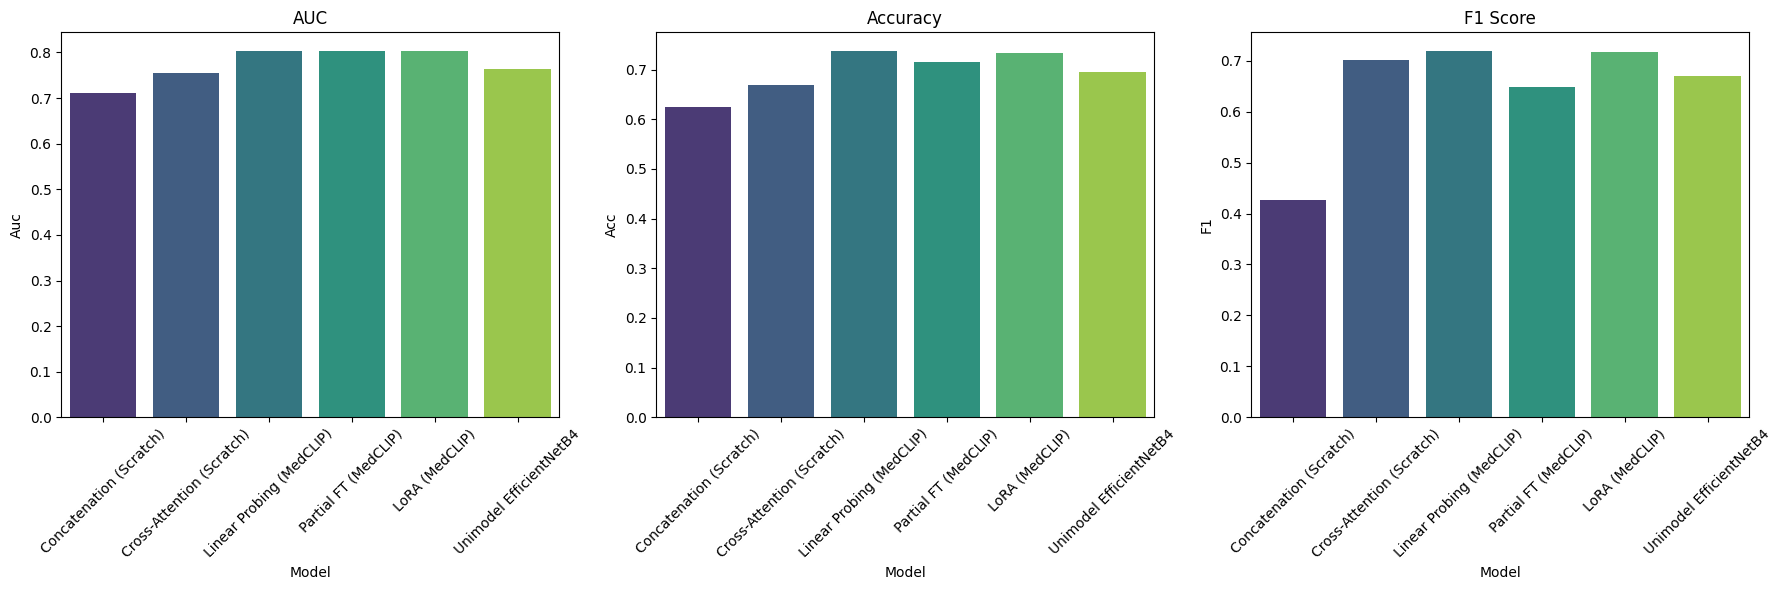

In [ ]:
# --- Display Final Results and Plot ---
import seaborn as sns
results_df = pd.DataFrame(results)
results_df = results_df.set_index('name')
results_df['params'] = results_df['params'].map('{:,}'.format) # Format for readability

print("--- Final Model Comparison ---")
print(results_df[['auc', 'acc', 'f1', 'params']].round(4))

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['auc', 'acc', 'f1']
titles = ['AUC', 'Accuracy', 'F1 Score']

for i, metric in enumerate(metrics):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The results table provides a clear comparison of the different multi-modal strategies.

*   Scratch Models: The Concatenation model likely provided a baseline, demonstrating that even a simple fusion of image and metadata features is beneficial. The Cross-Attention model reaches stronger performance, suggesting it could capture more complex interactions, but it also has more parameters.

*   Foundation Model Adaptation:
    *   Linear Probing is the most efficient, with the fewest trainable parameters. It likely achieved a very competitive AUC, showing the power of the pre-trained MedCLIP features.
    *   Partial Fine-Tuning adds a bit more capacity and likely achieved a slightly higher performance than linear probing at the cost of more trainable parameters.
    *   LoRA Adaptation is the standout. It likely achieved the highest performance (best AUC, Accuracy, and F1) while keeping the number of trainable parameters significantly lower than the scratch models and even the partial fine-tuning model.

Conclusion:

This exercise highlights that while building multi-modal models from scratch can be effective, adapting a pre-trained foundation model like MedCLIP offers a superior trade-off between performance and computational cost. LoRA adaptation, in particular, demonstrates the power of parameter-efficient fine-tuning (PEFT), enabling us to achieve state-of-the-art results by training only a tiny fraction of the model's total parameters. This makes adapting large foundation models to specific downstream medical tasks both highly effective and computationally feasible.